<a href="https://colab.research.google.com/github/pranshumalik14/ece421-labs-hw/blob/main/labs/lab1/lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 1: Logistic Regression

In this lab, we will be creating a binary classifier using Logistic Regression first implemented using Numpy and then using Tensorflow. The classifier has to be trained on the `notMNIST` dataset, and particularly classify only between the letters `C` (positive class, labelled `1`) and `J` (negative class, labelled `0`). This dataset, representing the ground truth, will be represented as $\mathcal{D}= \{(\mathbf{x}_i, y_i)\}_{i=1}^N$, where there are $N$ datavectors $\mathbf{x}_i \in \mathbb{R}^d$ and labels $y_i \in \{0, 1\}$.

## 1. Logistic Regression with Numpy

We use the following model for computing the probability of a datavector $\mathbf{x}_n\in\mathbb{R}^d$ belonging to a particular class $y_n\in \{0, 1\}$:

$$\hat{p}_\mathbf{w}(y_n\mid \mathbf{x}_n) = \sigma\left((2y_n-1)(\mathbf{w}^\top\mathbf{x}_n + b)\right),$$

given the model parameters $\mathbf{w} \in \mathbb{R}^d$ (wieght) and $b \in \mathbb{R}$ (bias), and the logistic (or sigmoid) function $\sigma(z) = \frac{1}{1+e^{-z}}$.

However, to simply expressions we will augment our datavectors $\mathbf{x}_i$ with ones and accordingly increment the dimension of the weightvector, such that $\mathbf{x}_i = \begin{bmatrix}1 & x_1 & \ldots & x_d\end{bmatrix} \in \mathbb{R}^{d+1}$ and $\mathbf{w} = \begin{bmatrix}b & w_1 & \ldots & w_d \end{bmatrix}\in \mathbb{R}^{d+1}$. This will yield the (binary) label prediction probability to be:

$$\hat{p}_\mathbf{w}(y_n\mid \mathbf{x}_n) = \sigma\left((2y_n-1)(\mathbf{w}^\top\mathbf{x}_n)\right).$$
No changes are made to the label sequence $y_i$. Also note that the corresponding changes to function signatures were made, so the functions defined in this document (e.g. `loss` and `grad_loss`) will differ slightly from the lab handout.

### 1.1 Loss Function and Gradient 

We will use the regularized loss function (in-sample error) for minimization while training over the dataset:

$$\begin{align*}
E_{\text{in}, \lambda}(\mathbf{w}) &= \lambda||\mathbf{w}||^2 + \frac{1}{N}\sum_{n=1}^N -\log\left(\hat{p}_\mathbf{w}(y_n\mid \mathbf{x}_n)\right)\\
&= \lambda||\mathbf{w}||^2 + \frac{1}{N}\sum_{n=1}^N \big[-I(y_n=1)\log(\hat{p}_\mathbf{w}(1\mid \mathbf{x}_n)) -I(y_n=0)\log(\hat{p}_\mathbf{w}(0\mid \mathbf{x}_n))\big] \quad \triangleright \text{since } y_n \text{ only has two possibilities}\\
&= \lambda||\mathbf{w}||^2 + \frac{1}{N}\sum_{n=1}^N \big[-y_n\log(\hat{p}_\mathbf{w}(1\mid \mathbf{x}_n)) -(1-y_n)\log(1-\hat{p}_\mathbf{w}(1\mid \mathbf{x}_n))\big]\\
&= \lambda||\mathbf{w}||^2 + \frac{1}{N}\sum_{n=1}^N \big[y_n\log(1 + e^{-\mathbf{w}^\top\mathbf{x}_n})) +(1-y_n)\log(1+e^{\mathbf{w}^\top\mathbf{x}_n})\big],
\end{align*}
$$
where $\lambda > 0$ is the regularization constant and $I(p)$ is the identifier function defined to be, $I(p) = \begin{cases}1 & \text{predicate } p \text{ is true}\\ 0 & \text{predicate } p \text{ is false}\end{cases}$

The gradient of the loss function is:

$$
\begin{align*}
∇_{\mathbf{w}}E_{\text{in}, \lambda}(\mathbf{w}) &= ∇_{\mathbf{w}}\lambda||\mathbf{w}||^2 + \frac{1}{N}\sum_{n=1}^N ∇_{\mathbf{w}}\big[-y_n\log(\hat{p}_\mathbf{w}(1\mid \mathbf{x}_n)) -(1-y_n)\log(1-\hat{p}_\mathbf{w}(1\mid \mathbf{x}_n))\big]\\
&=2\lambda\mathbf{w} + \frac{1}{N}\sum_{n=1}^N\big[-y_n(1+e^{-\mathbf{w}^\top\mathbf{x}_n})∇_{\mathbf{w}}(1+e^{-\mathbf{w}^\top\mathbf{x}_n})^{-1}-(1-y_n)(1+e^{\mathbf{w}^\top\mathbf{x}_n})∇_{\mathbf{w}}(1+e^{\mathbf{w}^\top\mathbf{x}_n})^{-1}\big]\\
&=2\lambda\mathbf{w} + \frac{1}{N}\sum_{n=1}^N\big[-y_n\mathbf{x}_n\underbrace{\frac{e^{-\mathbf{w}^\top\mathbf{x}_n}}{(1+e^{-\mathbf{w}^\top\mathbf{x}_n})}}_{\sigma(-\mathbf{w}^\top\mathbf{x}_n) = 1-\sigma(\mathbf{w}^\top\mathbf{x}_n)}+(1-y_n)\mathbf{x}_n\underbrace{\frac{e^{\mathbf{w}^\top\mathbf{x}_n}}{(1+e^{\mathbf{w}^\top\mathbf{x}_n})}}_{\sigma(\mathbf{w}^\top\mathbf{x}_n)}\big]\\
&=2\lambda\mathbf{w} + \frac{1}{N}\sum_{n=1}^N \mathbf{x}_n\left(\sigma(\mathbf{w}^\top\mathbf{x}_n)-y_n\right)\\
&=2\lambda\mathbf{w} + \frac{1}{N}\mathbf{X}^\top\left(\boldsymbol{\sigma}(\mathbf{X}\mathbf{w})-\mathbf{y}\right), 
\end{align*}
$$

where $\mathbf{X} = \begin{bmatrix}\mathbf{x}_1^\top\\\vdots\\\mathbf{x}_N^\top\end{bmatrix}\in \mathbb{R}^{N\times(d+1)}$ is the datamatrix, $\mathbf{y} \in \{0,1\}^{N}$ is the labelvector, and $\boldsymbol{\sigma}(\cdot)$ is a vector function acting element-wise on the input vector by applying the (scalar) logistic function.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
sigmoid = lambda z: 1 / (1 + np.exp(-z))

In [4]:
def loss(w, X, ys, reg_lambda):
    Xw = X @ w # logits
    logit_CE_loss = ys*np.log(1 + np.exp(-Xw)) + (1 - ys)*np.log(1 + np.exp(Xw))
    # return regularization penalty + cross entropy loss
    return reg_lambda*np.linalg.norm(w)**2 + logit_CE_loss.mean()

In [5]:
def grad_loss(w, X, ys, reg_lambda):
    return 2*reg_lambda*w + 1/X.shape[0]*(X.T @ (sigmoid(X@w) - ys))

Here we also define the `accuracy` function that will evaluate the mean of the number of misclassifications, giving us a probability of $\hat{p}_{\mathbf{w}}(y_n\mid\mathbf{x}_n)$ favoring the opposite label. This will help us objectively evaluate how the loss corresponds to the performance of the linear (logistic regression) model.

In [6]:
def accuracy(w, X, ys):
    p_hat  = sigmoid(X@w)    # predicted probability for yn=1
    ys_hat = np.round(p_hat) # corresponding predicted labels
    return (ys_hat == ys).mean()

### 1.2 Gradient Descent Implementation

To minimize the loss function, we implement the gradient descent algorithm which iteratively updates the weightvector along the locally-optimum direction, which is opposite to the direction of the loss function. More precisely, we implement the following,

$$\mathbf{w}_{k+1} = \mathbf{w}_k - ϵ\underbrace{∇_{\mathbf{w}}E_{\text{in}, λ}(\mathbf{w}_k)}_{\texttt{grad_loss}(\mathbf{w}_k)},$$

where $ϵ > 0$ is the learning rate or step size and $k \in \mathbb{N}$ is the epoch or batch-iteration index. We will be referring to this algorithm as Full Gradient Descent (GD) since it evaluates the gradient over the entire training dataset. This algorithm will terminate once the maximum number of epochs is reached or if the weight update was insignficant (lower than `error_tol`), meaning that the optimization procedure has likely converged.

In [7]:
def grad_descent(w, Xs, Ys, eps, epochs, reg_lambda, error_tol=1e-7):
    # Xs = [X_train, X_valid (optional), X_test (optional)]
    # Ys = [ys_train, ys_valid (optional), ys_test (optional)]
    w_opt     = np.copy(w)
    loss_hist = np.empty((0,Xs.shape[0]), float)
    acc_hist  = np.empty((0,Xs.shape[0]), float)
    for epoch in range(epochs):
        grad_w = grad_loss(w, Xs[0], Ys[0], reg_lambda)
        w_opt  = w - eps*grad_w
        if np.linalg.norm(w-w_opt)**2 < error_tol:
            break
        else:
            w = w_opt
        loss_hist = np.append(loss_hist, [[loss(w, Xs[i], Ys[i], reg_lambda) for i in range(Xs.shape[0])]], axis=0)
        acc_hist  = np.append(acc_hist, [[accuracy(w, Xs[i], Ys[i]) for i in range(Xs.shape[0])]], axis=0)
    return w_opt, loss_hist, acc_hist

Now we will test our implementation in Numpy (and later another done in TensorFlow) on real data. The `notMNIST` dataset has images of size $28\times 28$, which we flatten to form feature vectors of dimension $d=784$. Note that they will later be augmented with ones at the start to account for the bias term coupled into the weightvector.

In [8]:
# load data
def loadDataGDrive():
    with np.load('/content/drive/MyDrive/Colab Notebooks/notMNIST.npz') as dataset:
        Data, Target = dataset['images'], dataset['labels']
        posClass = 2
        negClass = 9
        dataIndx = (Target==posClass) + (Target==negClass)
        Data = Data[dataIndx]/255.
        Target = Target[dataIndx].reshape(-1, 1)
        Target[Target==posClass] = 1
        Target[Target==negClass] = 0
        np.random.seed(421)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data, Target = Data[randIndx], Target[randIndx]
        trainData, trainTarget = Data[:3500], Target[:3500]
        validData, validTarget = Data[3500:3600], Target[3500:3600]
        testData, testTarget = Data[3600:], Target[3600:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

x_train, x_valid, x_test, ys_train, ys_valid, ys_test = loadDataGDrive()

In [9]:
# augment and reshape datavectors
X_train = np.concatenate([np.ones((x_train.shape[0])).reshape(-1, 1), x_train.reshape(x_train.shape[0], -1)], axis=1)
X_valid = np.concatenate([np.ones((x_valid.shape[0])).reshape(-1, 1), x_valid.reshape(x_valid.shape[0], -1)], axis=1)
X_test  = np.concatenate([np.ones((x_test.shape[0])).reshape(-1, 1), x_test.reshape(x_test.shape[0], -1)], axis=1)

# cast labels to float for error-free numerical calculations
ys_train, ys_valid, ys_test = ys_train.astype(float), ys_valid.astype(float), ys_test.astype(float)

# data for gradient descent
Xs     = np.array([X_train, X_valid, X_test], dtype=object)    # training, validation, and testing data
Ys     = np.array([ys_train, ys_valid, ys_test], dtype=object) # training, validation, and testing labels

In [10]:
def plot_learning_history(title, loss_hist, acc_hist):
    # loss_hist = [train_loss, valid_loss, test_loss]
    # acc_hist  = [train_acc, valid_acc, test_acc]
    f, ax  = plt.subplots(1, 2, figsize=(8,4))
    labels = ["Train", "Validation", "Test"]

    for i in range(loss_hist.shape[1]):
        ax[0].plot(loss_hist[:, i], label=labels[i]) # plot loss history on left
        ax[1].plot(acc_hist[:, i], label=labels[i])  # plot accuracy history on right
    
    # add lables and title
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()
    f.suptitle(title, fontsize=14, y=1.03)
    return plt.tight_layout()

### 1.3 Tuning the Learning Rate

We now run our logistic regression model or (binary) classifier with learning rates $ϵ\in\{0.005, 0.001, 0.0001\}$ and no regularization.

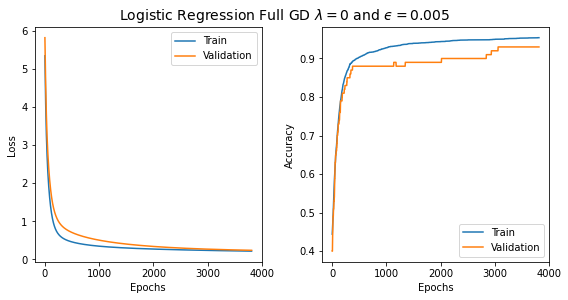

In [38]:
w_init = np.random.normal(0.001, 0.99, (X_train.shape[1], 1)) # initial weight vector
_, loss_history, accuracy_history = grad_descent(w_init, Xs, Ys, 0.005, 5000, 0)
title  = r"Logistic Regression Full GD $\lambda={}$ and $ϵ={}$".format(0, 0.005)
plot_learning_history(title, loss_history[:, 0:2], accuracy_history[:, 0:2])

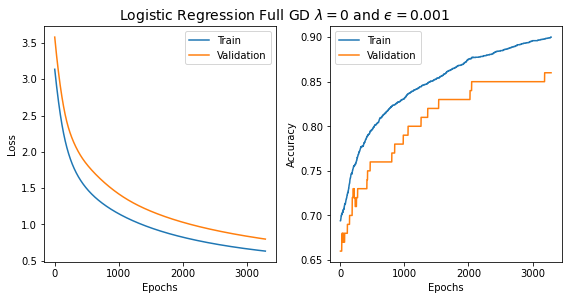

In [25]:
w_init = np.random.normal(0.001, 0.99, (X_train.shape[1], 1)) # initial weight vector
_, loss_history_eps_0p001, accuracy_history_eps_0p001 = grad_descent(w_init, Xs, Ys, 0.001, 5000, 0)
title  = r"Logistic Regression Full GD $\lambda={}$ and $ϵ={}$".format(0, 0.001)
plot_learning_history(title, loss_history_eps_0p001[:, 0:2], accuracy_history_eps_0p001[:, 0:2])

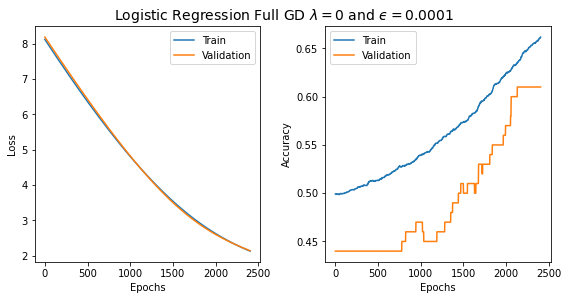

In [16]:
w_init = np.random.normal(0.001, 0.99, (X_train.shape[1], 1)) # initial weight vector
_, loss_history_eps_0p0001, accuracy_history_eps_0p0001 = grad_descent(w_init, Xs, Ys, 0.0001, 5000, 0)
title  = r"Logistic Regression Full GD $\lambda={}$ and $ϵ={}$".format(0, 0.0001)
plot_learning_history(title, loss_history_eps_0p0001[:, 0:2], accuracy_history_eps_0p0001[:, 0:2])

It can be visually inferred from above that $ϵ=0.005$ is the best learning rate in the set since it achieves the quickest convergence in minimizing the loss function and the highest accuracy (approximately $0.958$ and $0.938$ over the training and validation datasets respectively, in the current run) compared to other learning rates that are visibly slower for the problem of interest.

### 1.4 Generalization

To ensure that the loss function is not being artificially reduced by increasing the weights, regularize the loss function by penalizing larger entries in the weightvector. This also ensures better convergence characteristics as the search is bounded and results in a better performing model. Notice here that our formulation of the regularized loss function differs slightly from what is given in the lab (which divides $λ$ by $2$), but we still follow the lab for the set of values for $λ$ to compare. Hence more than quantititvely, we will compare the performance qualitively between the parameters.

Below are the results for $λ\in\{0.001, 0.1, 0.5\}$

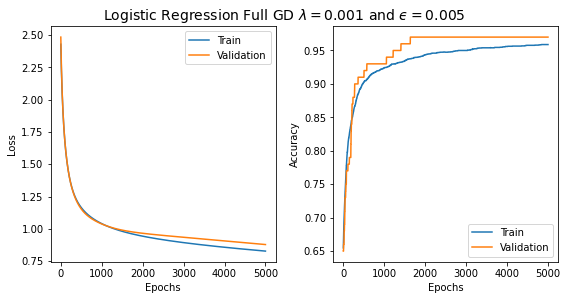

In [45]:
w_init = np.random.normal(0.001, 0.99, (X_train.shape[1], 1)) # initial weight vector
_, loss_history_lambda_0p001, accuracy_history_lambda_0p001 = grad_descent(w_init, Xs, Ys, 0.005, 5000, 0.001)
title  = r"Logistic Regression Full GD $\lambda={}$ and $ϵ={}$".format(0.001, 0.005)
plot_learning_history(title, loss_history_lambda_0p001[:, 0:2], accuracy_history_lambda_0p001[:, 0:2])

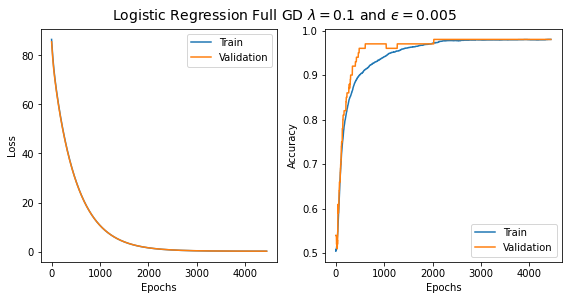

In [46]:
w_init = np.random.normal(0.001, 0.99, (X_train.shape[1], 1)) # initial weight vector
_, loss_history_lambda_0p1, accuracy_history_lambda_0p1 = grad_descent(w_init, Xs, Ys, 0.005, 5000, 0.1)
title  = r"Logistic Regression Full GD $\lambda={}$ and $ϵ={}$".format(0.1, 0.005)
plot_learning_history(title, loss_history_lambda_0p1[:, 0:2], accuracy_history_lambda_0p1[:, 0:2])

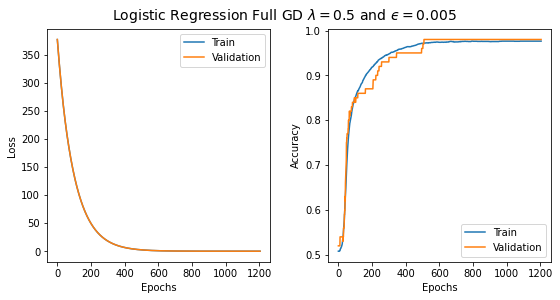

In [50]:
w_init = np.random.normal(0.001, 0.99, (X_train.shape[1], 1)) # initial weight vector
_, loss_history_lambda_0p5, accuracy_history_lambda_0p5 = grad_descent(w_init, Xs, Ys, 0.005, 5000, 0.5)
title  = r"Logistic Regression Full GD $\lambda={}$ and $ϵ={}$".format(0.5, 0.005)
plot_learning_history(title, loss_history_lambda_0p5[:, 0:2], accuracy_history_lambda_0p5[:, 0:2])

As can be seen above, regularizing the optimization results in better performance compared to the unregularized case, shown before. From the final
accuracy and losses achieved by the model, both $0.1$ and $0.5$ are good candidate values for the regularization constant. However, from the graphs, since $λ = 0.5$ results in quicker convergence than $λ = 0.1$, it will be the preferred
parameter.

We report that, with $λ = 0.5$, the model achieves an accuracy of $0.977$ and $0.981$ on the training and validation datasets respectively.

## 2. Logistic Regression in TensorFlow

We now implement the same binary model classification model in TensorFlow 2. We will be using the ADAM optimizer for the Mini-batch Stochastic Gradient Descent (SGD) algorithm to minimize the loss function and eventually learn from the dataset.

### 2.1 Logistic Regression Model Setup

In [18]:
%tensorflow_version 2.x
import tensorflow as tf2
import dataclasses as data

In [19]:
def loss_tf2(w, X, ys, reg_lambda):
    Xw = tf2.linalg.matmul(X, w) # logits
    reg_loss = 2*reg_lambda*tf2.nn.l2_loss(w)
    logits_CE_loss = tf2.nn.sigmoid_cross_entropy_with_logits(labels=ys, logits=Xw)
    return reg_loss + tf2.reduce_mean(logits_CE_loss)

In [20]:
def accuracy_tf2(w, X, ys):
    p_hat  = tf2.math.sigmoid(tf2.linalg.matmul(X, w)) # predicted probability for yn=1
    ys_hat = tf2.round(p_hat)                          # corresponding predicted labels
    return tf2.reduce_mean(tf2.cast(tf2.equal(ys_hat, ys), dtype=tf2.float64))

In [21]:
@data.dataclass # for ADAM optimizer and Mini-batch SGD
class Options:  # initial values same as default for keras.optimizers.Adam
    alpha: float = 0.001
    beta1: float = 0.9
    beta2: float = 0.999
    epsilon: float = 1e-07
    batchsz: int   = 500

In [22]:
def logistic_reg_tf2(Xs, Ys, reg_lambda, options, epochs=700):
    # Xs = [X_train, X_valid (optional), X_test (optional)]
    # Ys = [ys_train, ys_valid (optional), ys_test (optional)]

    # initialize the (augmented) weight vector
    w = tf2.Variable(initial_value=tf2.random.truncated_normal([Xs[0].shape[1]-1,1], stddev=0.5, dtype=tf2.float64))
    b = tf2.Variable(0.0, dtype=tf2.float64)
    w = tf2.Variable(tf2.concat([[[b]], w], axis=0))

    # initialize ADAM optimizer
    alpha, beta1, beta2, epsilon, _ = data.astuple(options)
    optimizer = tf2.keras.optimizers.Adam(learning_rate=alpha, beta_1=beta1, beta_2=beta2, epsilon=epsilon)

    # train model
    return train_logistic_reg_tf2_model(w, Xs, Ys, reg_lambda, optimizer, options, epochs)

### 2.2 Implementing Stochastic Gradient Descent

Here we implement the Mini-batch SGD algorithm using TensorFlow and run it for our problem using the default parameters for ADAM optimizer.

In [24]:
def shuffle_data(X, ys):
    # https://valueml.com/shuffle-the-training-data-in-tensorflow/
    indices = tf2.range(start=0, limit=X.shape[0], dtype=tf2.int32)
    shuffled_indices = tf2.random.shuffle(indices)

    shuffled_x = tf2.gather(X, shuffled_indices)
    shuffled_y = tf2.gather(ys, shuffled_indices)

    return shuffled_x, shuffled_y

In [25]:
def train_logistic_reg_tf2_model(w, Xs, Ys, reg_lambda, optimizer, options, epochs):
    # Xs = [X_train, X_valid (optional), X_test (optional)]
    # Ys = [ys_train, ys_valid (optional), ys_test (optional)]
    loss_hist   = np.empty((0,Xs.shape[0]), float)
    acc_hist    = np.empty((0,Xs.shape[0]), float)
    batch_size  = options.batchsz
    num_batches = int(Xs[0].shape[0]/batch_size)
    
    # mini-batch stochastic gradient descent
    for _ in range(epochs):
        X_shfld, ys_shfld = shuffle_data(Xs[0], Ys[0])
        
        for i in range(num_batches):
            batch_start, batch_end = i*batch_size, (i+1)*batch_size
            mini_X, mini_ys = X_shfld[batch_start:batch_end], ys_shfld[batch_start:batch_end]
            
            with tf2.GradientTape() as tape:
                tape.watch(w)
                train_loss = loss_tf2(w, mini_X, mini_ys, reg_lambda)
            
            grad = tape.gradient(train_loss, w)
            optimizer.apply_gradients([(grad, w)])

        loss_hist = np.append(loss_hist, [[loss_tf2(w, Xs[i], Ys[i], reg_lambda).numpy() for i in range(Xs.shape[0])]], axis=0)
        acc_hist  = np.append(acc_hist, [[accuracy_tf2(w, Xs[i], Ys[i]).numpy() for i in range(Xs.shape[0])]], axis=0)    
    return w, loss_hist, acc_hist

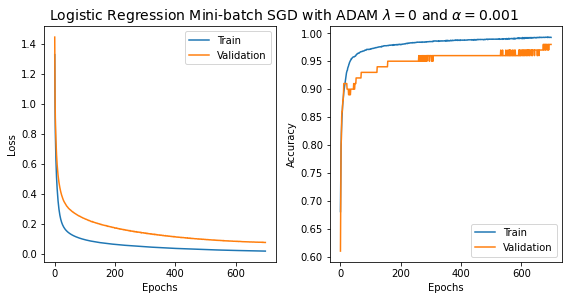

In [32]:
_, loss_history_tf2, accuracy_history_tf2 = logistic_reg_tf2(Xs, Ys, 0.0, Options())
title  = r"Logistic Regression Mini-batch SGD with ADAM $\lambda={}$ and $\alpha={}$".format(0, 0.001)
plot_learning_history(title, loss_history_tf2[:, 0:2], accuracy_history_tf2[:, 0:2])

### 2.3 Batch Size Investigation

We now train and validate the model for mini-batches of size $B\in\{100, 700, 1750\}$. This is done without regularization and with the default learning rate for ADAM, i.e., $\alpha=0.001$.

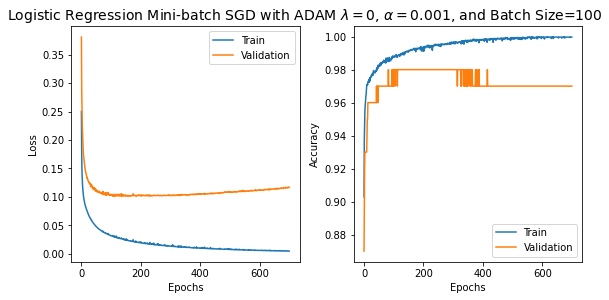

In [27]:
_, loss_history_bsz100, accuracy_history_bsz100 = logistic_reg_tf2(Xs, Ys, 0.0, Options(batchsz=100))
title  = r"Logistic Regression Mini-batch SGD with ADAM $\lambda={}$, $\alpha={}$, and Batch Size={}".format(0, 0.001, 100)
plot_learning_history(title, loss_history_bsz100[:, 0:2], accuracy_history_bsz100[:, 0:2])

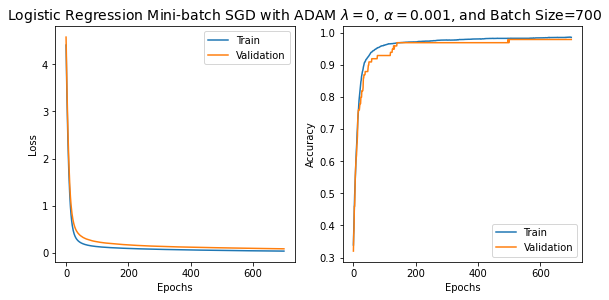

In [28]:
_, loss_history_bsz700, accuracy_history_bsz700 = logistic_reg_tf2(Xs, Ys, 0.0, Options(batchsz=700))
title  = r"Logistic Regression Mini-batch SGD with ADAM $\lambda={}$, $\alpha={}$, and Batch Size={}".format(0, 0.001, 700)
plot_learning_history(title, loss_history_bsz700[:, 0:2], accuracy_history_bsz700[:, 0:2])

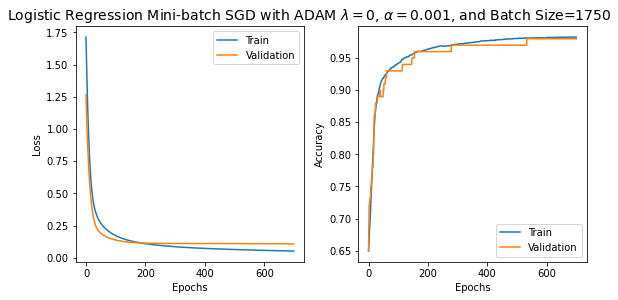

In [29]:
_, loss_history_bsz1750, accuracy_history_bsz1750 = logistic_reg_tf2(Xs, Ys, 0.0, Options(batchsz=1750))
title  = r"Logistic Regression Mini-batch SGD with ADAM $\lambda={}$, $\alpha={}$, and Batch Size={}".format(0, 0.001, 1750)
plot_learning_history(title, loss_history_bsz1750[:, 0:2], accuracy_history_bsz1750[:, 0:2])

From the plots above, it is clear that a smaller batch size results in the model overfitting to the training data which is observed by the training accuracy and divergence from the validation loss curve. This is because with a smaller batch size, the model runs an optimization step more often and hence SGD converges quickly on
training data while performing poorly on the validation data relative to other batch sizes, which shows the loss in its ability to generalize. With a smaller batch size, the model is more susceptible to fitting to "noise" in the training data, whereas with a larger batch size, the model learns more slowly since it tends to search for a
more general minimum, and due to less frequent updates, it does not tend to learn the “noise”. From the validation loss, a batch size of $700$ results in the best performance and hence it would be a preferable range for our problem of interest as it achieves a balance in performance and rate of convergence.

### 2.4 Hyperparameter Investigation

We now investigate the model performance with varying its hyperparameters. Throughout this section, a batch size of $500$ a learning rate of $α = 0.001$ have been used with no loss regularization.

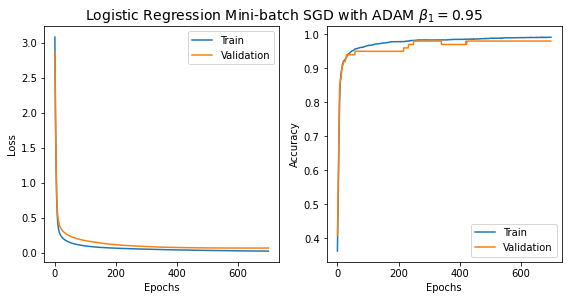

In [31]:
_, loss_history_beta1_0p95, accuracy_history_beta1_0p95 = logistic_reg_tf2(Xs, Ys, 0.0, Options(beta1=0.95))
title  = r"Logistic Regression Mini-batch SGD with ADAM $\beta_1={}$".format(0.95)
plot_learning_history(title, loss_history_beta1_0p95[:, 0:2], accuracy_history_beta1_0p95[:, 0:2])

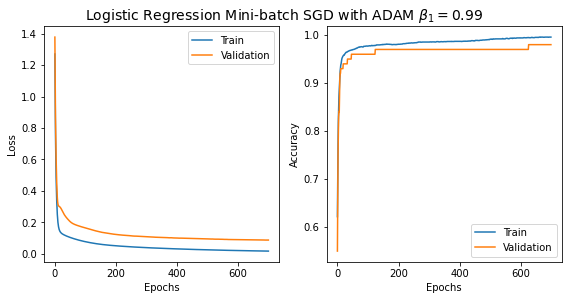

In [40]:
_, loss_history_beta1_0p99, accuracy_history_beta1_0p99 = logistic_reg_tf2(Xs, Ys, 0.0, Options(beta1=0.99))
title  = r"Logistic Regression Mini-batch SGD with ADAM $\beta_1={}$".format(0.99)
plot_learning_history(title, loss_history_beta1_0p99[:, 0:2], accuracy_history_beta1_0p99[:, 0:2])

In ADAM, $𝛽_1$ controls the exponential decay rate for the first moment estimates, which dictates how many past training steps to are utilized by the optimizer to improve its gradients. From above, it can be see that $𝛽_1 = 0.95$ resulted in better performance as shown by the loss and accuracy plots.


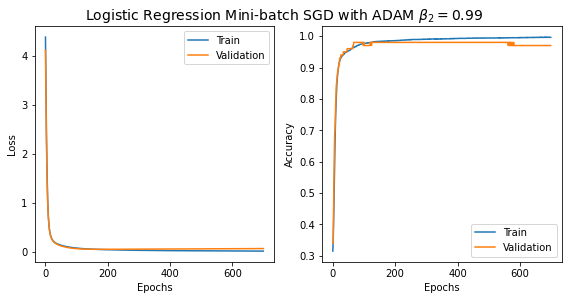

In [41]:
_, loss_history_beta2_0p99, accuracy_history_beta2_0p99 = logistic_reg_tf2(Xs, Ys, 0.0, Options(beta2=0.99))
title  = r"Logistic Regression Mini-batch SGD with ADAM $\beta_2={}$".format(0.99)
plot_learning_history(title, loss_history_beta2_0p99[:, 0:2], accuracy_history_beta2_0p99[:, 0:2])

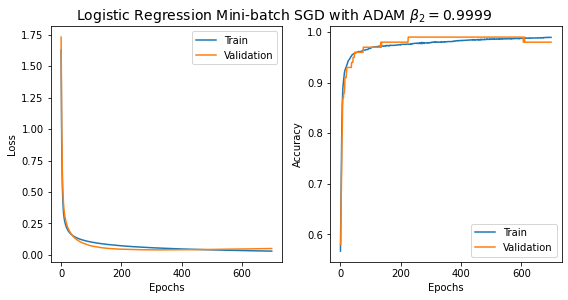

In [42]:
_, loss_history_beta2_0p9999, accuracy_history_beta2_0p9999 = logistic_reg_tf2(Xs, Ys, 0.0, Options(beta2=0.9999))
title  = r"Logistic Regression Mini-batch SGD with ADAM $\beta_2={}$".format(0.9999)
plot_learning_history(title, loss_history_beta2_0p9999[:, 0:2], accuracy_history_beta2_0p9999[:, 0:2])

In ADAM, $𝛽_2$ controls the exponential decay rate for the second moment estimates, which has a similar effect as $β_1$. From above, it can be seen that $𝛽_2 = 0.99$ resulted in more consistent and better performance as shown by the loss and accuracy plots, though it is very similar to $𝛽_2 = 0.9999$.

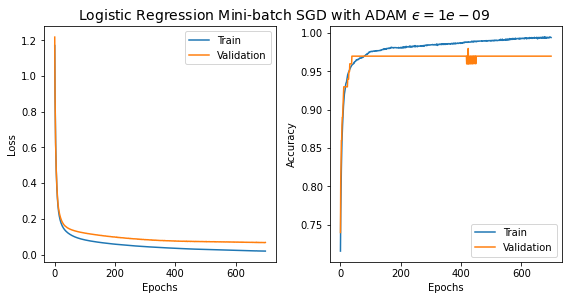

In [43]:
_, loss_history_eps_1em09, accuracy_history_eps_1em09 = logistic_reg_tf2(Xs, Ys, 0.0, Options(epsilon=1e-09))
title  = r"Logistic Regression Mini-batch SGD with ADAM $ϵ={}$".format(1e-09)
plot_learning_history(title, loss_history_eps_1em09[:, 0:2], accuracy_history_eps_1em09[:, 0:2])

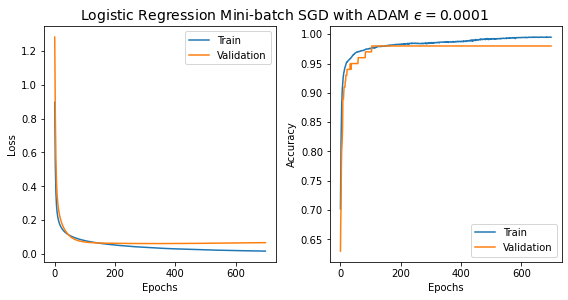

In [44]:
_, loss_history_eps_1em04, accuracy_history_eps_1em04 = logistic_reg_tf2(Xs, Ys, 0.0, Options(epsilon=1e-04))
title  = r"Logistic Regression Mini-batch SGD with ADAM $ϵ={}$".format(1e-04)
plot_learning_history(title, loss_history_eps_1em04[:, 0:2], accuracy_history_eps_1em04[:, 0:2])

In ADAM, $ϵ$ is a hyperparameter used to prevent errors resulting from division from zero. Higher the values of $ϵ$ will result in more offset of the gradients from their "optimal" values, yielding worse performance which can be see from the loss plot for $ϵ=0.0001$. Hence, $𝜀 = 10^{-9}$ is a better choice as shown by the consistent loss and accuracy plots.

### 2.5 Comparison against Full Gradient Descent

We show again the loss and accuracy histories while training the logistic regression model using Full GD ($λ=0$, $ϵ=0.005$) and Mini-batch SGD with ADAM ($λ=0$, $α=0.001$, $B=500$).

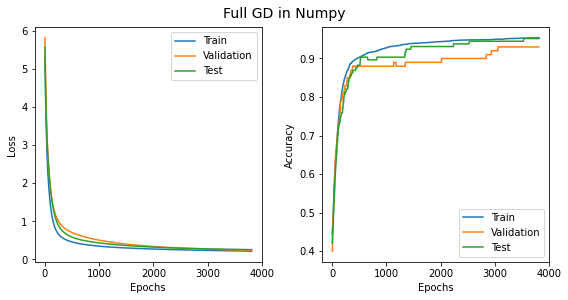

In [39]:
plot_learning_history("Full GD in Numpy", loss_history, accuracy_history)

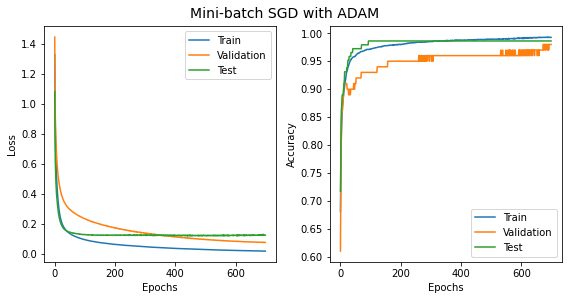

In [33]:
plot_learning_history("Mini-batch SGD with ADAM", loss_history_tf2, accuracy_history_tf2)

Overall, it is easy to observe that the convergence rate for SGD with ADAM is much faster with better accuracy than Full GD due to the more robust nature of the chosen optimizer resulting from dynamic learning rates. A slightly smoother reduction of loss and increase in accuracy is also visible from the plots for Full GD due to using the full (the largest in this context) dataset for training. Also, noticing the frequent earlier (than $5000$ epochs) termination of Full GD, we can conclude that it is more likely to stop upon reaching a "flat" region than Mini-batch SGD with ADAM that is able to jump out of local minima and land in a region that is (hopefully) more optimal, due to its formulation and implementation. This shows that for this problem, ADAM performs better as an optimizer than Full GD to
achieve better results and faster. 